In [245]:
import pretty_midi
import numpy as np
import glob
import mido
import os
import tensorflow as tf
import random

notes_array = np.load('/Users/rich/Desktop/AI-music/NumpyArray/notes_array.npy')
velocities_array = np.load('/Users/rich/Desktop/AI-music/NumpyArray/velocities_array.npy')

#normalize
#帶來以下好處:
#1. 處理不同尺度的數據
#2. 加快模型收斂速度

#change shape
notes_normalized = notes_array.reshape(-1, 1) / int(notes_array.max())
velocities_normalized = velocities_array.reshape(-1, 1) / float(velocities_array.max())

# combine notes and velocities
combined_data = np.concatenate((notes_normalized, velocities_normalized), axis=1)
combined_data.shape

(2599480, 2)

In [246]:
sequence_length = 10
inputs = []
targets = []

for i in range(len(combined_data) - sequence_length):
    inputs.append(combined_data[i:i+sequence_length])
    targets.append(combined_data[i+sequence_length])

inputs = random.sample(inputs, 1000)
targets = random.sample(targets, 1000)
#split data
split_index = int(0.7 * len(inputs)) 

train_inputs = np.array(inputs[:split_index])
train_targets = np.array(targets[:split_index])

test_inputs = np.array(inputs[split_index:])
test_targets = np.array(targets[split_index:])

In [247]:
len(inputs), len(targets)

(1000, 1000)

In [248]:
train_inputs

array([[[0.32283465, 0.88976378],
        [0.47244094, 0.7007874 ],
        [0.53543307, 0.83464567],
        ...,
        [0.47244094, 0.73228346],
        [0.33858268, 0.83464567],
        [0.33858268, 0.71653543]],

       [[0.42519685, 0.28346457],
        [0.42519685, 0.28346457],
        [0.64566929, 0.28346457],
        ...,
        [0.54330709, 0.37795276],
        [0.48818898, 0.56692913],
        [0.30708661, 0.51968504]],

       [[0.28346457, 1.        ],
        [0.33070866, 0.68503937],
        [0.54330709, 0.37007874],
        ...,
        [0.54330709, 0.37007874],
        [0.2992126 , 1.        ],
        [0.33070866, 0.68503937]],

       ...,

       [[0.5511811 , 0.25984252],
        [0.54330709, 0.40944882],
        [0.5511811 , 0.44094488],
        ...,
        [0.5511811 , 0.16535433],
        [0.54330709, 0.22834646],
        [0.5511811 , 0.25984252]],

       [[0.52755906, 0.51181102],
        [0.55905512, 0.72440945],
        [0.5984252 , 0.67716535],
        .

In [249]:
class CVAE(tf.keras.Model):
    def __init__(self, latent_dim):
        super(CVAE, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=(train_inputs.shape[1], train_inputs.shape[2])),
            tf.keras.layers.LSTM(64, return_sequences=True),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LSTM(32),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dense(16, activation='relu'),
            tf.keras.layers.Dense(latent_dim * 2)  
        ])

        self.decoder = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
            tf.keras.layers.RepeatVector(train_inputs.shape[1]),  
            tf.keras.layers.LSTM(32, return_sequences=True),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LSTM(64, return_sequences=True),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dense(train_inputs.shape[2]) 
        ])

    @tf.function
    def sample(self, eps=None):
        if eps is None:
            eps = tf.random.normal(shape=(10, self.latent_dim))
        return self.decode(eps, apply_sigmoid=True)

    def encode(self, x):
        mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
        return mean, logvar

    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * .5) + mean

    def decode(self, z, apply_sigmoid=False):
        logits = self.decoder(z)
        if apply_sigmoid:
            probs = tf.sigmoid(logits)
            return probs
        return logits

optimizer = tf.keras.optimizers.legacy.Adam()

def log_normal_pdf(sample, mean, logvar, raxis=1):
    log2pi = tf.math.log(2. * np.pi)
    return tf.reduce_sum(
        -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
        axis=raxis)

def compute_loss(model, x):
    mean, logvar = model.encode(x)
    z = model.reparameterize(mean, logvar)
    x_logit = model.decode(z)
    cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
    logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2])
    logpz = log_normal_pdf(z, 0., 0.)
    logqz_x = log_normal_pdf(z, mean, logvar)
    return -tf.reduce_mean(logpx_z + logpz - logqz_x)

@tf.function
def train_step(inputs, targets, model, optimizer):
    batch_inputs = tf.cast(inputs, dtype=tf.float32)
    batch_targets = tf.cast(targets, dtype=tf.float32)
    with tf.GradientTape() as tape:
        loss = compute_loss(model, batch_inputs)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss


epochs = 3
latent_dim = 2
num_examples_to_generate = 1
losses = []

random_vector_for_generation = [[random.random() for _ in range(latent_dim)] for _ in range(num_examples_to_generate)]

# 將random_vector_for_generation轉換為Tensor並指定形狀為(5, 2)
random_vector_for_generation = tf.convert_to_tensor(random_vector_for_generation, dtype=tf.float32)
random_vector_for_generation = tf.reshape(random_vector_for_generation, shape=(num_examples_to_generate, latent_dim))

model = CVAE(latent_dim)

In [250]:
random_vector_for_generation 

<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[0.74458504, 0.9192963 ]], dtype=float32)>

In [251]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_inputs, train_targets)).shuffle(len(train_inputs)).batch(64)

for epoch in range(epochs):
    epoch_loss = 0
    num_batches = 0
    for batch_inputs, batch_targets in train_dataset:
        batch_loss = train_step(batch_inputs, batch_targets, model, optimizer)
        epoch_loss += batch_loss
        num_batches += 1
        
    avg_loss = epoch_loss / num_batches
    print('Epoch {} Loss: {:.6f}'.format(epoch + 1, avg_loss))
    losses.append(avg_loss)

2023-07-23 15:38:25.168896: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-07-23 15:38:25.633276: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-07-23 15:38:25.881285: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-07-23 15:38:26.135327: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-07-23 15:38:26.293520: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-07-23 15:38:26.648439: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-07-23 15:38:26.937003: I tensorflow/core/grappler/optimizers/cust

Epoch 1 Loss: 13.628186
Epoch 2 Loss: 13.193670
Epoch 3 Loss: 13.091020


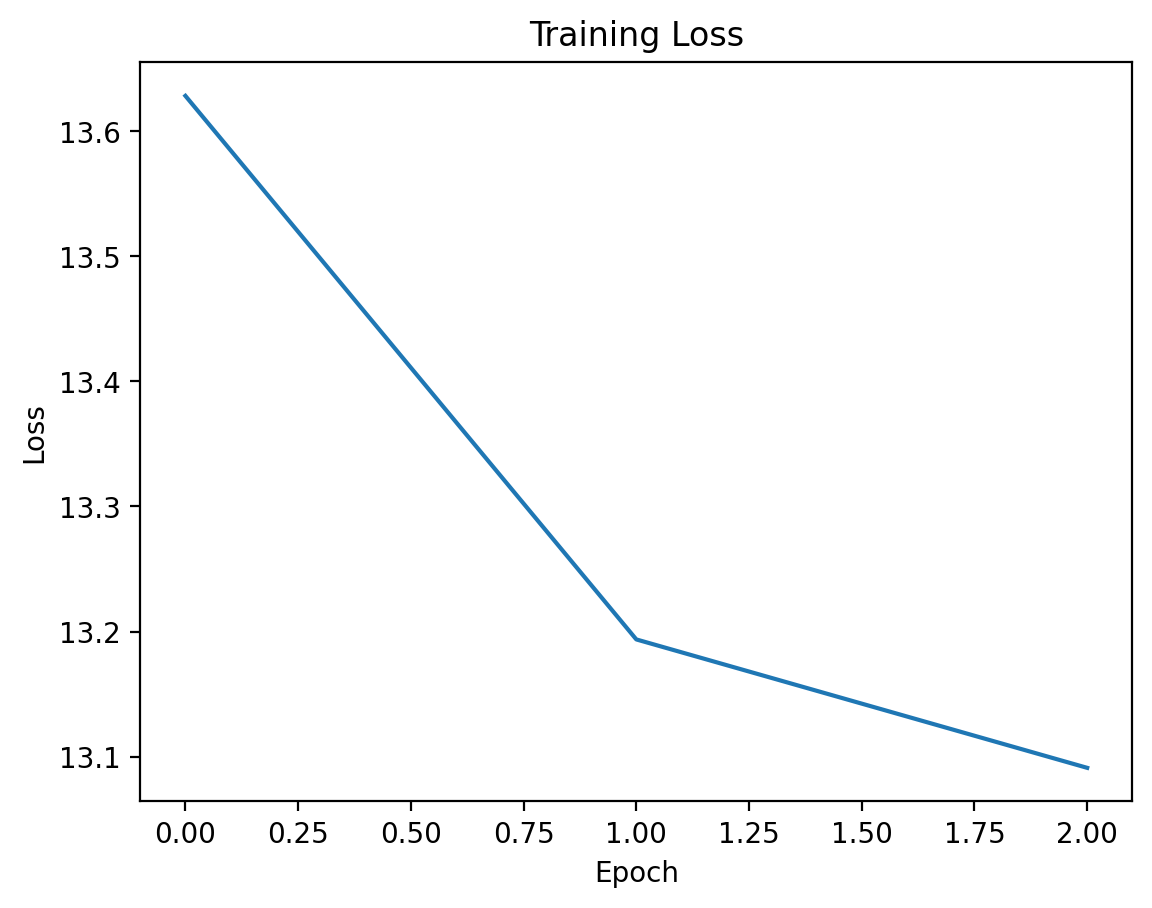

In [252]:
#plot loss
import matplotlib.pyplot as plt

plt.plot(losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [253]:
from music21 import stream, note, tempo

generated_samples = model.sample(random_vector_for_generation)
generated_samples_denormalized = generated_samples * np.array([notes_array.max(), velocities_array.max()])
generated_samples_denormalized = np.round(generated_samples_denormalized, 0)

for i in range(generated_samples_denormalized.shape[0]):
    generated_sequence = generated_samples_denormalized[i]
    
    music_stream = stream.Stream()
    
    for note_data in generated_sequence:
        new_note = note.Note()
        new_note.pitch.midi = int(note_data[0])
        new_note.volume.velocity = int(note_data[1])
        music_stream.append(new_note)
        
    path = '/Users/rich/Desktop/AI-Music/Generated_Music/CVAE'
    music_stream.write('midi', fp=path + 'generated_music_{}.mid'.format(i))


2023-07-23 15:38:34.662169: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-07-23 15:38:34.754313: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-07-23 15:38:34.895987: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [254]:
generated_samples

<tf.Tensor: shape=(1, 10, 2), dtype=float32, numpy=
array([[[0.47066376, 0.59233844],
        [0.46491134, 0.61481196],
        [0.46005884, 0.6346299 ],
        [0.4559953 , 0.6518023 ],
        [0.45262584, 0.66651   ],
        [0.4498639 , 0.6790086 ],
        [0.44762954, 0.68957317],
        [0.4458489 , 0.6984695 ],
        [0.44445452, 0.70594066],
        [0.4433852 , 0.71220183]]], dtype=float32)>

In [255]:
generated_samples_denormalized

array([[[60., 75.],
        [59., 78.],
        [58., 81.],
        [58., 83.],
        [57., 85.],
        [57., 86.],
        [57., 88.],
        [57., 89.],
        [56., 90.],
        [56., 90.]]], dtype=float32)